In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from tied_utils import simulated_tied_ddm_norm, tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn
from scipy.integrate import quad
from pyvbmc import VBMC
import corner
import random
from tqdm import tqdm

from tied_utils_decay2 import tied_abs_units_decay, prob_of_hitting_down_in_norm_units, decay_sigmoid, rho_E_minus_small_t_NORM_TIED_fn
from scipy.integrate import trapezoid
import pandas as pd

# params

In [31]:
# Stim params
# ILD_arr = [-6, -3, 0, 3, 6]
# ABL_arr = [20, 40, 60]

# ILD_arr = [1, -1, 2, -2, 4, -4, 8, -8, 16, -16]
ILD_arr = [2, -2, 8  ,-8]
ABL_arr = [20, 40, 60]

t_non_decision = 0.02
rate_lambda = 0.2
T_0 = 1 * 1e-3
theta_E = 20
dt = 1e-4

# gamma, mu_d, sigma_d, alpha
gamma = 0.0351
mu_d = 0.1
sigma_d = 0.05
alpha = 0.3

decay_params = {'gamma': gamma, 'mu_d': mu_d, 'sigma_d': sigma_d, 'alpha': alpha}
# sim params
N_sim = int(50e3)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [3]:
import pickle
with open('sim_results_time_varying_evidence.pkl', 'rb') as f:
    sim_results_og = pickle.load(f)

In [4]:
# remove elements if 'choice' is none
sim_results = [x for x in sim_results_og if x['choice'] is not None]
print(f"Number of valid simulations: {len(sim_results)}")

nan_sim_results = [x for x in sim_results_og if x['choice'] is None]
print(f"Number of NaN simulations: {len(nan_sim_results)}")

Number of valid simulations: 50000
Number of NaN simulations: 0


(0.0, 2.0)

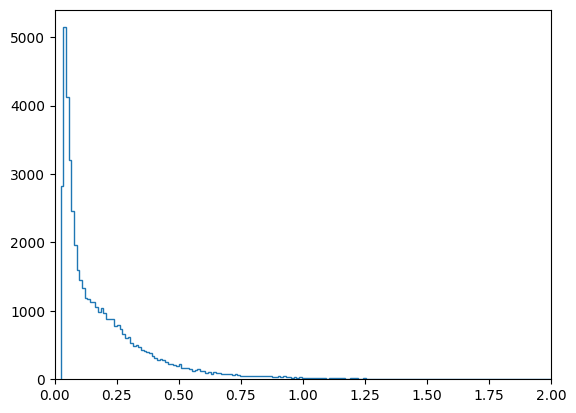

In [5]:
plt.hist([res['rt'] for res in sim_results], bins=250, histtype='step');
plt.xlim(0,2)

# Likelihood check

In [6]:
ABL = ABL_arr[0]
ILD = ILD_arr[0]
data_bins=np.arange(0, 2, 0.01)
data_t_pts = data_bins[:-1] + (data_bins[1] - data_bins[0])/2

theory_bins = np.arange(0, 3, 5e-4)
t_pts = theory_bins[:-1] + (theory_bins[1] - theory_bins[0])/2


likelihood_up = np.zeros(len(t_pts))
likelihood_down = np.zeros(len(t_pts))
omega = (2 / (T_0 * (theta_E**2))) * (10**( (rate_lambda * ABL) / 20))

for idx, rt in enumerate(t_pts):
    dtau_by_dt = omega * decay_sigmoid(rt-t_non_decision, gamma, mu_d, sigma_d, alpha)
    likelihood_up[idx] = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, -theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    likelihood_down[idx] = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, theta_E, t_non_decision, omega, decay_params, dtau_by_dt)


Area of up hist: 0.7210711528158583
Area of up theory: 0.7152040013350117
Area of down hist: 0.2786902725161921
Area of down theory: 0.2847009799388514


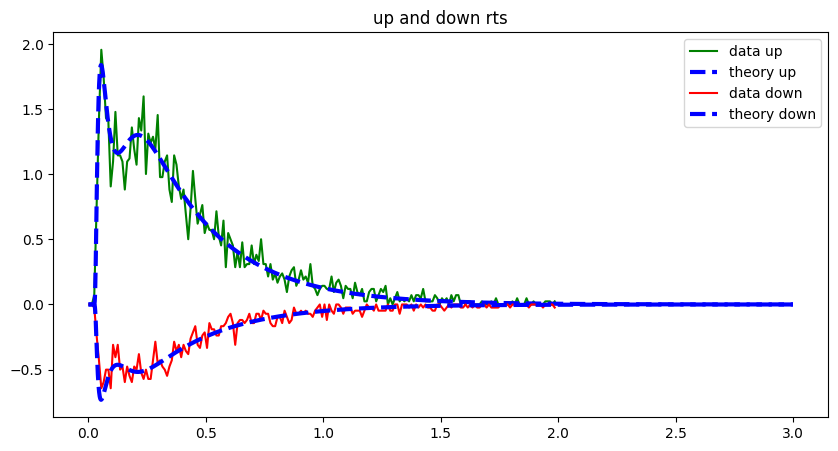

In [7]:
up_rts = [res['rt'] for res in sim_results if res['choice'] == 1 and res['ABL'] == ABL and res['ILD'] == ILD]
down_rts = [res['rt'] for res in sim_results if res['choice'] == -1 and res['ABL'] == ABL and res['ILD'] == ILD]

up_rt_hist, _ = np.histogram(up_rts, bins=data_bins, density=True)
down_rt_hist, _ = np.histogram(down_rts, bins=data_bins, density=True)

N_total = len([res['rt'] for res in sim_results if res['ABL'] == ABL and res['ILD'] == ILD])
N_up = len(up_rts)
N_down = len(down_rts)

plt.figure(figsize=(10, 5))
plt.plot(data_t_pts, up_rt_hist*(N_up/N_total), label='data up', color='g')
plt.plot(t_pts, likelihood_up, label='theory up', ls='--', color='b', lw=3)

plt.plot(data_t_pts, -down_rt_hist*(N_down/N_total), label='data down',  color='r')
plt.plot(t_pts, -likelihood_down, label='theory down', ls='--', color='b', lw=3)

plt.legend()
plt.title('up and down rts')
print(f'Area of up hist: {trapezoid(up_rt_hist, data_t_pts) * N_up/N_total}')
print(f'Area of up theory: {trapezoid(likelihood_up, t_pts)}')

print(f'Area of down hist: {trapezoid(down_rt_hist, data_t_pts) * N_down/N_total}')
print(f'Area of down theory: {trapezoid(likelihood_down, t_pts)}')

In [8]:
theory_all = np.zeros_like(t_pts)
for idx, rt in enumerate(t_pts):
    dtau_by_dt = omega * decay_sigmoid(rt-t_non_decision, gamma, mu_d, sigma_d, alpha)
    likelihood_up = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, -theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    likelihood_down = prob_of_hitting_down_in_norm_units(rt, ILD, rate_lambda, theta_E, t_non_decision, omega, decay_params, dtau_by_dt)
    theory_all[idx] = likelihood_up + likelihood_down

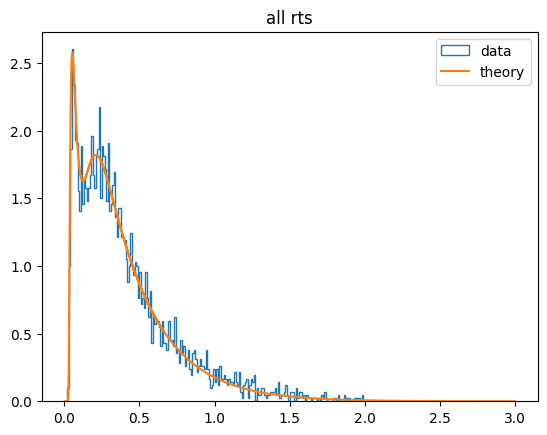

In [9]:
all_rts = [res['rt'] for res in sim_results if res['ABL'] == ABL and res['ILD'] == ILD]
plt.hist(all_rts, bins=data_bins, histtype='step', density=True, label='data');

plt.step(t_pts, theory_all, label='theory')
plt.legend()
plt.title('all rts');

# loglike fn

In [10]:
def compute_loglike(res, rate_lambda, theta_E, T_0, t_non_decision):
    ILD = res['ILD']
    ABL = res['ABL']
    choice = res['choice']
    rt = res['rt']

    
    if choice == 1:
        prob = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, -theta_E, T_0, t_non_decision)
    elif choice == -1:
        prob = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision)

    if prob <= 0:
        return np.log(1e-50)
    else:
        return np.log(prob)

def tied_loglike_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, rate_lambda, theta_E, T_0, t_non_decision, \
                                                               ) for res in sim_results)
    loglike = np.sum(all_loglike)

    return loglike

# Bounds

In [11]:
t_non_decision_bounds = [0*(1e-3), 50*(1e-3)]
rate_lambda_bounds = [0, 0.3]
T_0_bounds = [0.1*(1e-3), 1.5*(1e-3)]
theta_E_bounds = [5, 60]
# gamma_bounds = [0.01, 0.1]
# mu_d_bounds = [0.05, 0.2]
# sigma_d_bounds = [0.01, 0.1]
# alpha_bounds = [0.1, 0.5]

t_non_decision_plausible_bounds = [10*(1e-3), 30*(1e-3)]
rate_lambda_plausible_bounds = [0.15, 0.25]
T_0_plausible_bounds = [0.7*(1e-3), 1.2*(1e-3)]
theta_E_plausible_bounds = [15, 35]
# gamma_plausible_bounds = [0.02, 0.05]
# mu_d_plausible_bounds = [0.07, 0.15]
# sigma_d_plausible_bounds = [0.03, 0.07]
# alpha_plausible_bounds = [0.2, 0.4]


# True params
# rate_lambda = 0.076
# theta_E = 50.7
# T_0 = 0.19*(1e-3)
# t_non_decision = 78*(1e-3)

# Prior

In [12]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def tied_prior_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], \
                                            rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], \
                                            theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], \
                                            T_0_plausible_bounds[1], T_0_bounds[1])
    t_non_decision_logpdf = trapezoidal_logpdf(t_non_decision, t_non_decision_bounds[0], t_non_decision_plausible_bounds[0], \
                                            t_non_decision_plausible_bounds[1], t_non_decision_bounds[1])
    
   
    
    return rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_non_decision_logpdf

# prior + likelihood

In [13]:
def tied_joint_fn(params):
    return tied_loglike_fn(params) + tied_prior_fn(params)

# run vbmc

In [15]:
lb = np.array([rate_lambda_bounds[0], theta_E_bounds[0], T_0_bounds[0], t_non_decision_bounds[0]])
ub = np.array([rate_lambda_bounds[1], theta_E_bounds[1], T_0_bounds[1], t_non_decision_bounds[1]])
plb = np.array([rate_lambda_plausible_bounds[0], theta_E_plausible_bounds[0], T_0_plausible_bounds[0], t_non_decision_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], theta_E_plausible_bounds[1], T_0_plausible_bounds[1], t_non_decision_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
t_non_decision_0 = np.random.uniform(t_non_decision_plausible_bounds[0], t_non_decision_plausible_bounds[1])

x0 = np.array([rate_lambda_0, theta_E_0, T_0_0, t_non_decision_0])

vbmc = VBMC(tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       10707.02     15279.37          inf        2        inf     start warm-up
     1         15       17089.03      3126.56     14657.80        2        inf     
     2         20       21081.65       416.53      3605.47        2   7.48e+04     
     3         25       22587.49       153.28      1167.97        2    2.5e+04     
     4         30       23100.30        25.37       498.47        2   1.01e+04     
     5         35       23520.19        15.60       529.10        2   1.03e+04     
     6         40       23783.06        17.71       323.28        2   6.32e+03     
     7         45       40024.95     22397.3

/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rlab/raghavendra/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


    28        150       26075.53      3645.58    119212.35        2      2e+06     
    29        155       25057.54       170.43        93.78        2   5.52e+03     trim data
    30        160       25015.30       152.35     19677.70        2   3.29e+05     
    31        165       24953.47         0.04        97.61        2   1.83e+03     
    32        170       24953.47         0.01         0.03        2      0.516     
    33        175       24953.46         0.00         0.01        2      0.256     
    34        180       24953.43         0.00         0.00        2        0.2     end warm-up
    35        185       24953.50         0.00         0.01        2      0.416     
    36        190       24953.45         0.00         0.00        2      0.196     
    37        195       24953.55         0.00         0.02        5      0.652     
    38        200       24953.60         0.00         0.02        8      0.422     rotoscale, undo rotoscale
    39        205       24953.6

# corner

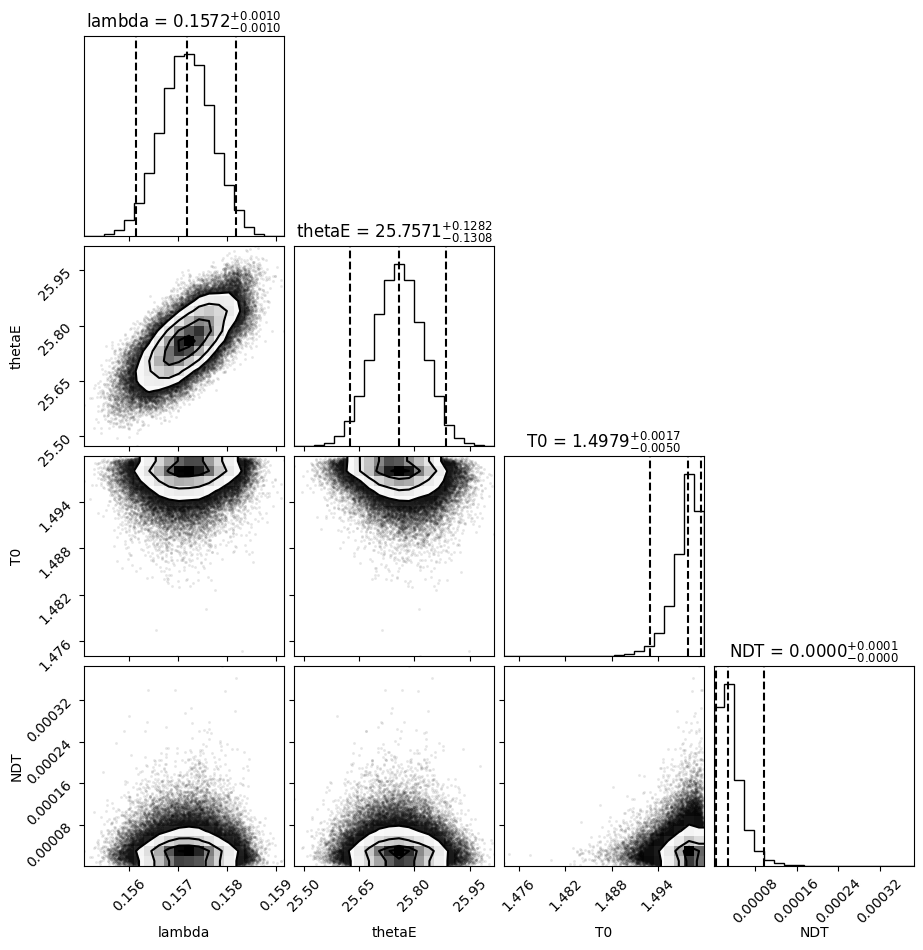

In [16]:
vp_samples = vp.sample(int(1e5))[0]

rate_lambda_samp = vp_samples[:, 0]
theta_E_samp = vp_samples[:, 1]
T_0_samp = vp_samples[:, 2]*1e3
t_non_decision_samp = vp_samples[:, 3]
# sigma_d_samp = vp_samples[:, 6]
# alpha_samp = vp_samples[:, 7]

combined_samples = np.transpose(np.vstack((rate_lambda_samp, theta_E_samp, T_0_samp, t_non_decision_samp)))
param_labels = ['lambda', 'thetaE', 'T0', 'NDT']
true_arr = [rate_lambda, theta_E, T_0*1e3, t_non_decision]
# corner_span = [(0.07, 0.085), (46, 55), (0.16*(1e-3), 0.25*(1e-3)), (77*(1e-3), 79*(1e-3))]

corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], truths=true_arr, title_fmt=".4f"  );
 

In [ ]:
ILD_arr, ABL_arr

# Diagnostics

In [17]:
# rate_lambda_samp = vp_samples[:, 0]
# theta_E_samp = vp_samples[:, 1]
# T_0_samp = vp_samples[:, 2]*1e3
# t_non_decision_samp = vp_samples[:, 3]
# gamma_samp = vp_samples[:, 4]
# mu_d_samp = vp_samples[:, 5]
# sigma_d_samp = vp_samples[:, 6]
# alpha_samp = vp_samples[:, 7]

rate_lambda_mean = np.mean(rate_lambda_samp)
theta_E_mean = np.mean(theta_E_samp)
T_0_mean = np.mean(T_0_samp)
t_non_decision_mean = np.mean(t_non_decision_samp)



In [18]:
T_0_mean = T_0_mean * 1e-3
T_0_mean

0.0014974869768583372

In [19]:
def tied_abs_units_non_decay(ILD_arr, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt, max_time=100):
    ILD = np.random.choice(ILD_arr)
    ABL = np.random.choice(ABL_arr)


    max_steps = int(np.ceil(max_time / dt))
    t = np.arange(0, max_steps * dt, dt)
    dB = np.sqrt(dt)
    chi = 17.37

    common = (2 / T_0) * (10 ** (rate_lambda * ABL / 20))
    
    # decay = (1/c)*np.exp(-t / c) + c1
    decay = 1

    mu = common * (rate_lambda * ILD / chi) * decay
    sigma = np.sqrt(common * decay)
    
    noise = np.random.normal(0, dB, size=max_steps)
    
    increments = mu * dt + sigma * noise
    DV = np.cumsum(increments)
    
    crossing_indices = np.where((DV >= theta_E) | (DV <= -theta_E))[0]
    if crossing_indices.size > 0:
        t_cross = t[crossing_indices[0]]
        choice = +1 if DV[crossing_indices[0]] > theta_E else -1
        return {'choice': choice, 'rt': t_cross + t_non_decision, 'ILD': ILD,  'ABL': ABL}
    else:
        return {'choice': None, 'rt': np.nan, 'DV': DV}


In [21]:
fit_sim_results = Parallel(n_jobs=-1)(delayed(tied_abs_units_non_decay)(ILD_arr, ABL_arr, rate_lambda_mean, theta_E_mean, T_0_mean, t_non_decision_mean, dt) for _ in range(N_sim))


In [22]:
from diagnostics_class import Diagnostics

In [23]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df.head()

,choice,rt,ILD,ABL
0,1,0.0522,8,60
1,-1,0.0607,-2,40
2,-1,0.6520,-2,20
3,-1,0.0375,-8,20
4,1,0.0571,2,60


In [24]:
fit_results_df = pd.DataFrame(fit_sim_results)
fit_results_df.head()

,choice,rt,ILD,ABL
0,1,0.304733,2,20
1,-1,0.064433,-8,60
2,-1,0.177133,-8,40
3,1,0.047033,8,60
4,-1,0.096133,-2,60


In [25]:
# add correct column = 1if ILD* choice > 1,  else 0
sim_results_df['correct'] = (sim_results_df['ILD'] * sim_results_df['choice'] > 0).astype(int)

In [26]:
fit_results_df['correct'] = (fit_results_df['ILD'] * fit_results_df['choice'] > 0).astype(int)

In [27]:
sim_results_df['t_stim'] = 0
fit_results_df['t_stim'] = 0

In [28]:
sim_results_diag = Diagnostics(sim_results_df)
fit_results_diag = Diagnostics(fit_results_df)

/tmp/ipykernel_3506191/1567125089.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_rtd.legend(fontsize=12)
/tmp/ipykernel_3506191/1567125089.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_psy.legend(fontsize=18)


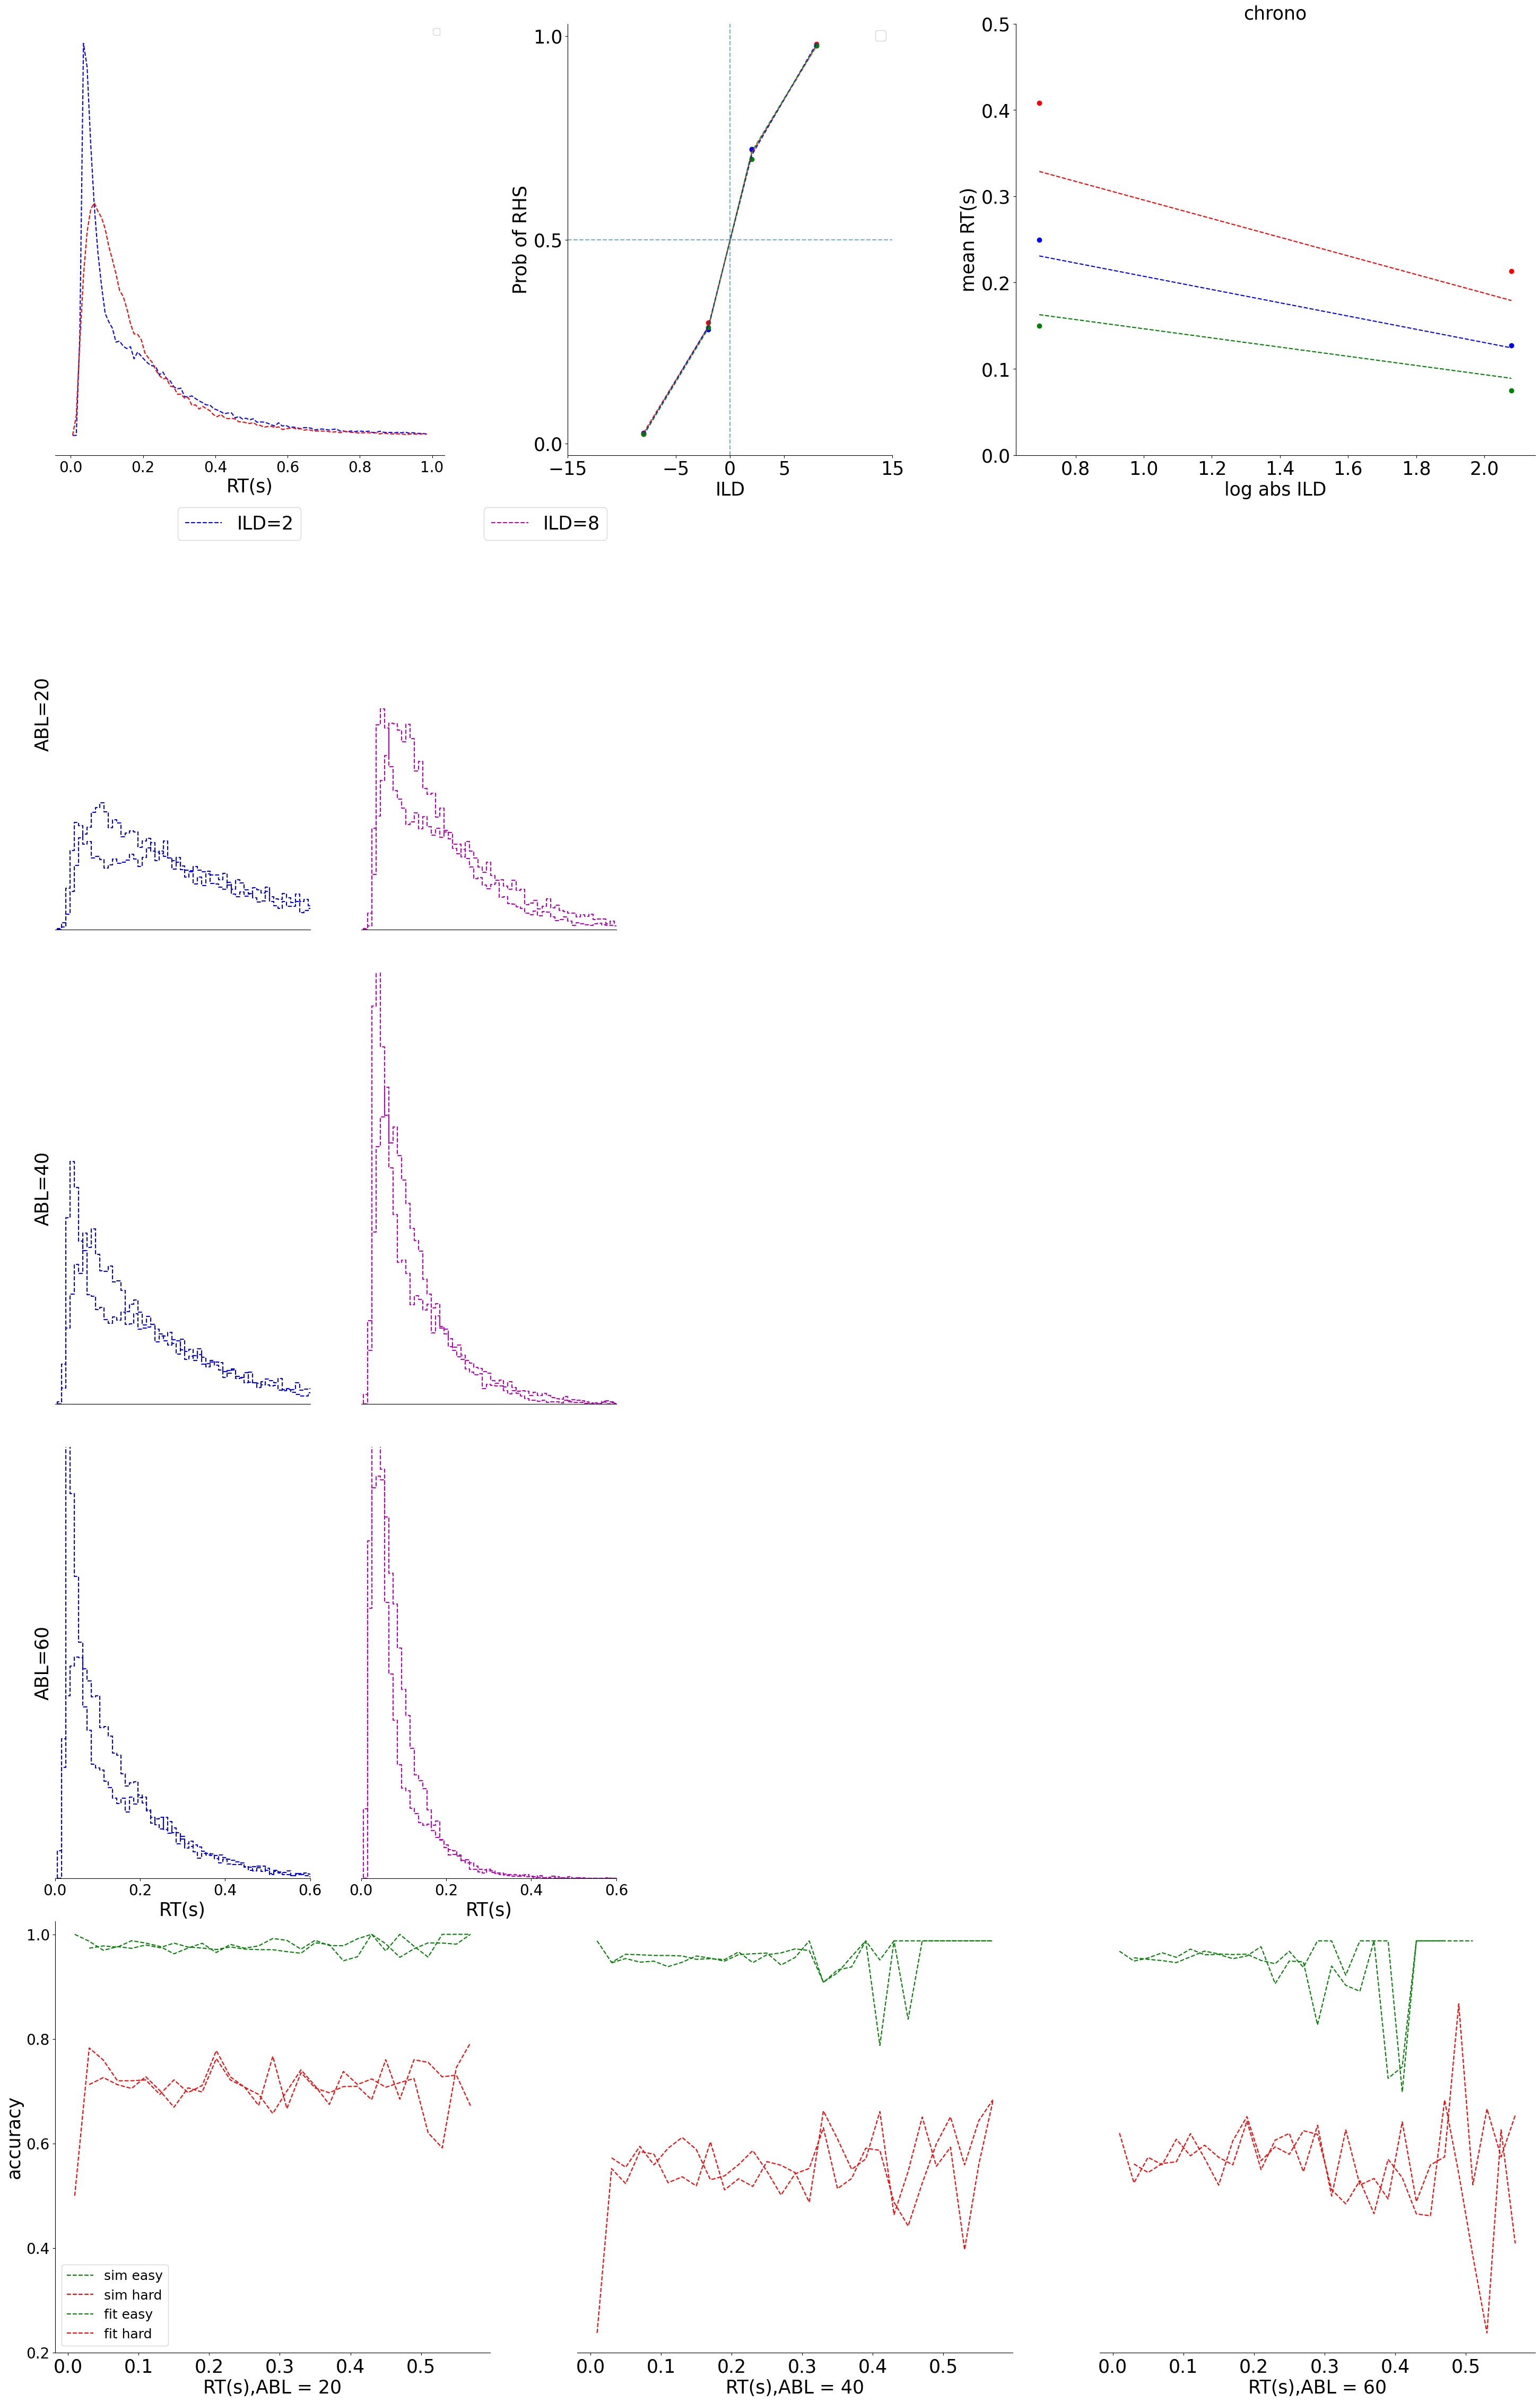

In [29]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 19*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1)

# --- 1) Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
    # subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    # wspace=0.09
)

# --- 2) Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r' ,2: 'b', 4: 'g', 8: 'm', 16: 'k'}

# 0 -grand RTD
bins = np.arange(0, 1, 0.01)
x, y = sim_results_diag.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, ls='--', color='b')

x,y = fit_results_diag.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, color='r', ls='--')


ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)


# 1 - psycho 
sim_psycho = sim_results_diag.plot_psycho()
all_ABL = sim_psycho.keys()
all_ILD = np.sort(ILD_arr)
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, sim_psycho[ABL], color=ABL_colors[ABL])

fit_psycho = fit_results_diag.plot_psycho()
for ABL in all_ABL:
    ax_psy.plot(all_ILD, fit_psycho[ABL], alpha=0.9, color=ABL_colors[ABL], ls='--')

ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob of RHS', fontsize=25)
# ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.set_xticks([-15, -5, 0, 5, 15])
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0, 0.5, 1.0])
ax_psy.axvline(0, linestyle='--', alpha=0.6)
ax_psy.axhline(0.5, linestyle='--', alpha=0.6)




# 2  - chrono
all_ABL = np.sort(sim_results_df['ABL'].unique())
all_ILD = np.sort(sim_results_df['ILD'].unique())
all_ILD = all_ILD[all_ILD > 0] 

sim_chrono = {}

for ABL in all_ABL:
    per_ILD_rt = np.zeros_like(all_ILD ,dtype=float)
    for idx, ILD in enumerate(all_ILD):
        filtered_df = sim_results_df[ (sim_results_df['ABL'] == ABL) \
                                    & (sim_results_df['ILD'].isin([ILD, -ILD])) ]
        mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace([np.nan, np.inf, -np.inf], np.nan).dropna().mean()
        per_ILD_rt[idx] = mean_rt
    sim_chrono[ABL] = per_ILD_rt


fit_chrono = {}
for ABL in all_ABL:
    per_ILD_rt = np.zeros_like(all_ILD ,dtype=float)
    for idx, ILD in enumerate(all_ILD):
        filtered_df = fit_results_df[ (fit_results_df['ABL'] == ABL) \
                                    & (fit_results_df['ILD'].isin([ILD, -ILD])) ]
        mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace([np.nan, np.inf, -np.inf], np.nan).dropna().mean()
        per_ILD_rt[idx] = mean_rt
    fit_chrono[ABL] = per_ILD_rt

for ABL in sim_chrono.keys():
    ax_chrono.scatter(np.log(all_ILD), sim_chrono[ABL], color=ABL_colors[ABL])
    ax_chrono.plot(np.log(all_ILD), fit_chrono[ABL], color=ABL_colors[ABL], ls='--')

# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel('log abs ILD', fontsize=25)
ax_chrono.set_ylabel('mean RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.set_ylim(0, 0.4)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_yticks(np.arange(0, 0.6, 0.1))

# RTDs per ABL
al_ILD = np.sort(ILD_arr)
pos_ILD = all_ILD[all_ILD > 0]
bins = np.arange(0, 1, 0.01)
t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])

row = 0

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    ABL = ABL_arr[a]
    for j, ILD in enumerate(pos_ILD):
        ax = fig.add_subplot(gs[row, j])  

        sim_pd = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']


        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        ax.step(t_pts,sim_rt_hist, linestyle='dashed', color=ILD_colors[ILD], label='sim')

        fit_pd = fit_results_df[(fit_results_df['ABL'] == ABL) & (fit_results_df['ILD'].isin([ILD, -ILD]))]
        fit_rt = fit_pd['rt'] - fit_pd['t_stim']

        fit_rt_hist, _ = np.histogram(fit_rt, density=True, bins=bins)
        ax.step(t_pts,fit_rt_hist, color=ILD_colors[ILD], label='fit', ls='--')



        if a == len(ABL_arr) - 1:
            ax.set_xlabel('RT(s)', fontsize=25)
        if j == 0:
            ax.set_ylabel(f'ABL={ABL}', fontsize=25)
            ax.tick_params(axis='y', which='major', labelsize=20)
        
        if a == 0:
            ax.legend([f'ILD={ILD}'], fontsize=25)

        # ax.legend(fontsize=18) # title covers it
        ax.set_xlim(0, 0.6)
        ax.set_ylim(0, 11)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(True)

        if j != 0:
            ax.spines['left'].set_visible(False)
        ax.set_yticks([])

        if a == len(ABL_arr) - 1:
            ax.tick_params(axis='both', which='major', labelsize=20)
        else:
            ax.set_xticks([])
    
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

hard_ILD = np.array([1, -1, 2, -2, 4, -4]); easy_ILD = np.array([8, -8, 16, -16])
bins = np.arange(0, 0.6, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df[(sim_results_df['ABL'] == ABL) & (sim_results_df['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # fit - easy
    fit_pd_easy = fit_results_df[(fit_results_df['ABL'] == ABL) & (fit_results_df['ILD'].isin(easy_ILD))]
    fit_pd_easy_diag = Diagnostics(fit_pd_easy)
    x, fit_easy_tacho = fit_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, fit_easy_tacho, label='fit easy', color='g', linestyle='--')

    # fit - hard
    fit_pd_hard = fit_results_df[(fit_results_df['ABL'] == ABL) & (fit_results_df['ILD'].isin(hard_ILD))]
    fit_pd_hard_diag = Diagnostics(fit_pd_hard)
    x, fit_hard_tacho = fit_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, fit_hard_tacho, label='fit hard', color='r', linestyle='--')
    

    
    ax_r.set_xlabel(f'RT(s),ABL = {ABL}', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    # ax_r.set_xlim(0, 0.6)
    # ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)
